# Quick Start

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import warnings

from orbit.models.dlt import DLTMAP, DLTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.utils.dataset import load_iclaims

## Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries from Jan 2010 - June 2018. This aims to mimick the dataset from the paper "Predicting the Present with Bayesian Structural Time Series" by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

In [2]:
df = load_iclaims()
df["claims"] = np.log(df["claims"])

In [3]:
test_size = 104
train_df = df[:-test_size]
test_df = df[-test_size:]

## MAP Fit and Predict with Stan

In [4]:
dlt = DLTMAP(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=2020,
)
dlt.fit(df=train_df)
predicted_df = dlt.predict(df=test_df)

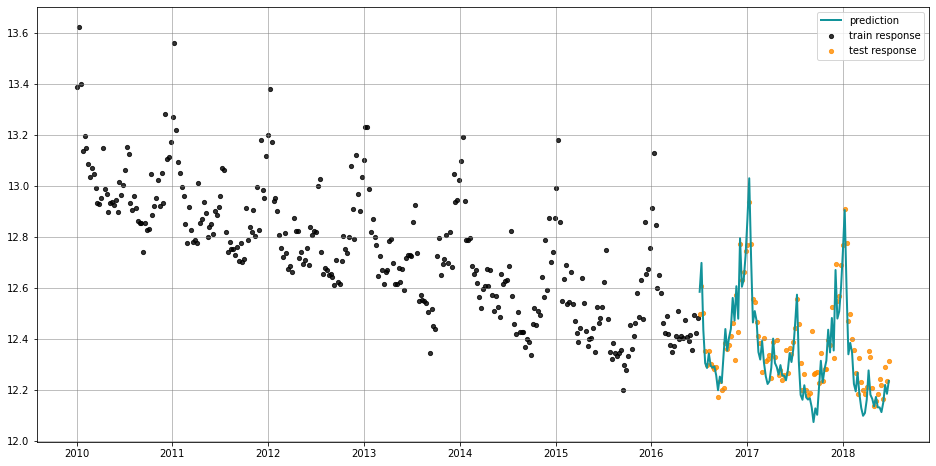

In [5]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col="week", actual_col="claims",
                    test_actual_df=test_df)

## Full Bayesian Fit and Predict with Stan

In [6]:
dlt = DLTFull(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=2020,
)
dlt.fit(df=train_df)
predicted_df = dlt.predict(df=test_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


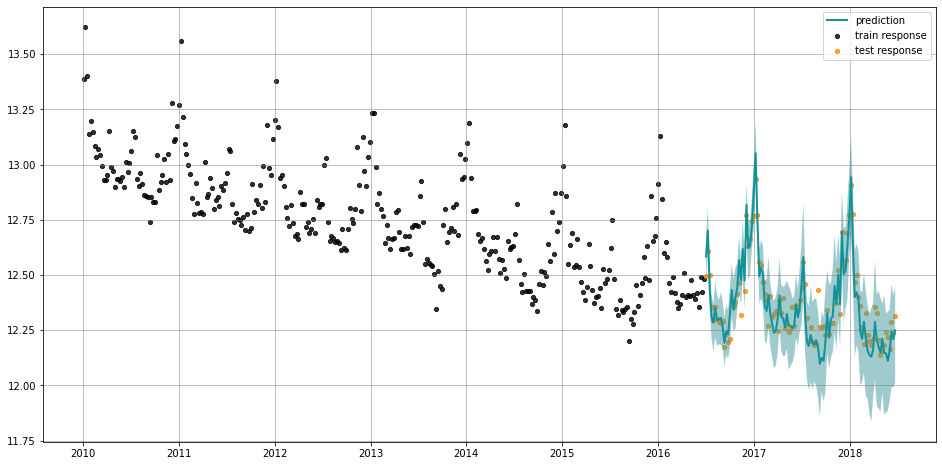

In [7]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col="week", actual_col="claims",
                    test_actual_df=test_df)